In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset

from attacks.watermark import WaterMarkAttack
from defences.util import dataset2tensor, get_correct_examples
from models.mnist import BaseModel
from models.torch_util import predict_numpy, predict, validate

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cpu
CPU threads: 4


In [5]:
PATH = os.path.join('..', 'data')
BATCH_SIZE = 128
N_ADV = 2000

In [6]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH, train=False, download=True, transform=transforms)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()

tensor_X_test, tensor_y_test = dataset2tensor(dataset_test)
X_test = tensor_X_test.cpu().detach().numpy()
y_test = tensor_y_test.cpu().detach().numpy()


In [7]:
print(X_train.shape, X_test.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)


## Load classifier

In [8]:
# Create Neural Network model
model = BaseModel().to(device)
loss = nn.CrossEntropyLoss()

In [9]:
PATH_MODEL = os.path.join('..', 'results', 'mnist_200.pt')
model.load_state_dict(torch.load(PATH_MODEL, map_location=torch.device('cpu')))

<All keys matched successfully>

## Remove missclassified samples

In [10]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss, device)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss, device)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 60000
Accuracy on 59827 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9852 filtered test examples: 100.0000%


In [11]:
def show_img(x, title):
    image = make_grid(torch.from_numpy(x)).permute(1, 2, 0).detach().numpy()
    plt.figure(figsize=(14, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

## Untargeted attacks

In [12]:
attack = WaterMarkAttack(eps=0.3, base=1.0, n_classes=10, x_min=0.0, x_max=1.0, targeted=False)
attack.fit(X_train, y_train)

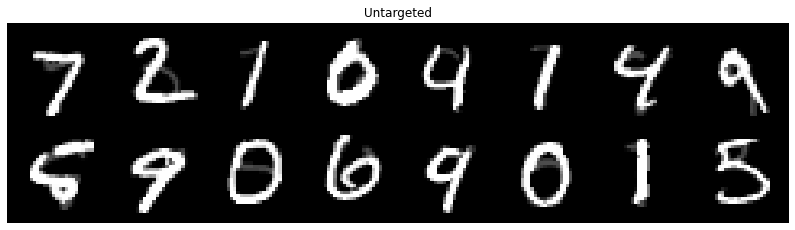

In [13]:
adv = attack.generate(X_test[:16], y_test[:16])
show_img(adv, 'Untargeted')

## Targeted attacks

In [14]:
attack = WaterMarkAttack(eps=0.3, base=1.0, n_classes=10, x_min=0.0, x_max=1.0, targeted=True)
attack.fit(X_train, y_train)

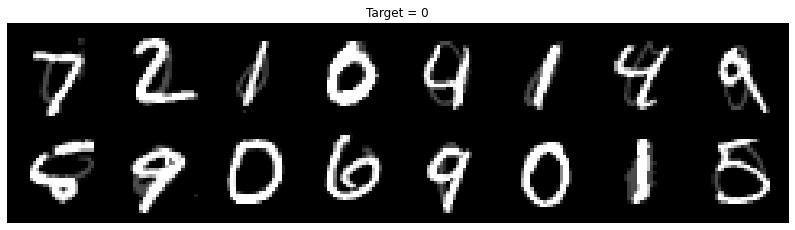

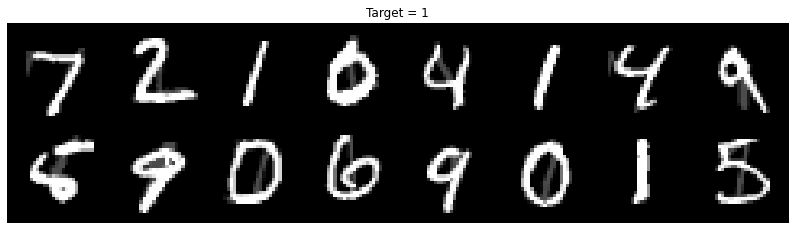

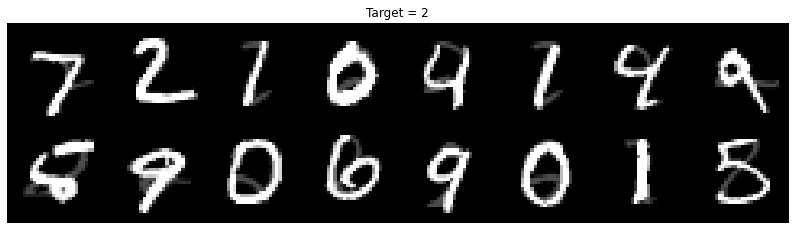

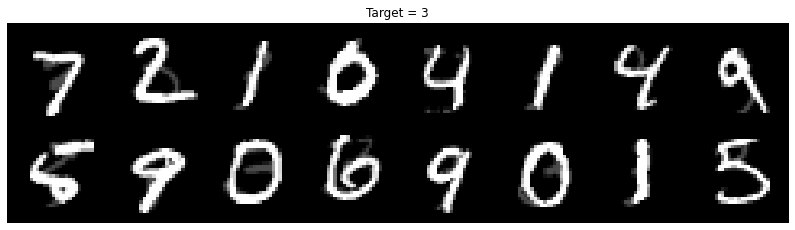

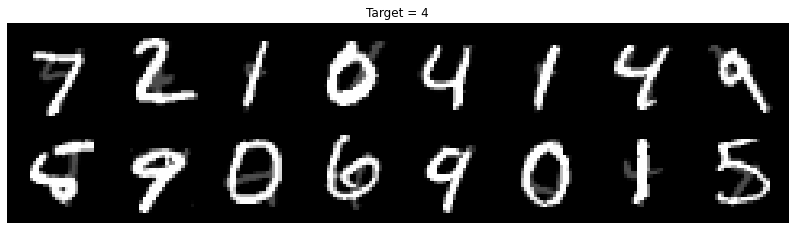

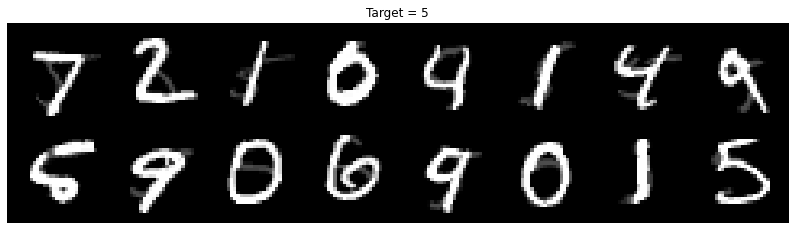

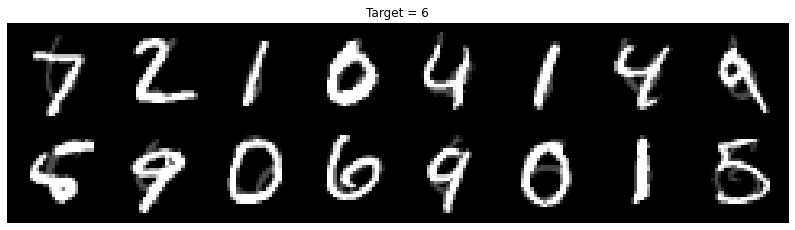

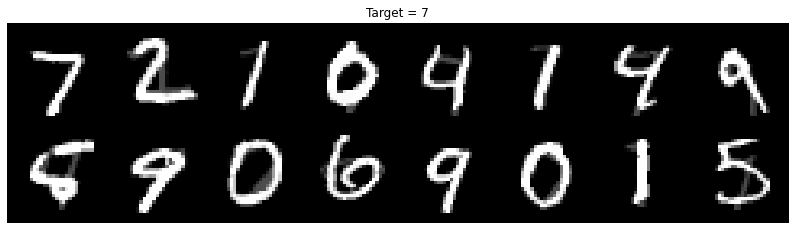

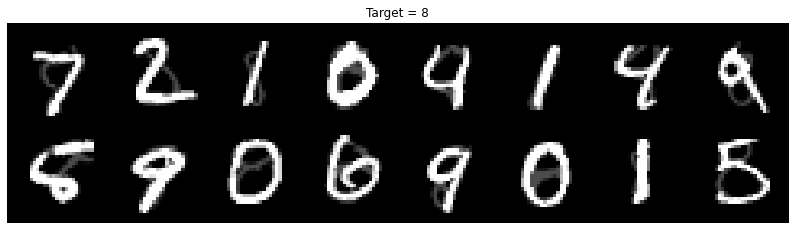

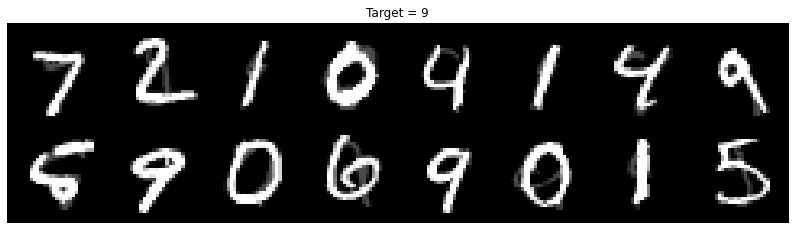

In [15]:
for i in range(10):
    adv = attack.generate(X_test[:16], i * np.ones(16, dtype=np.long))
    show_img(adv, 'Target = {}'.format(i))

## Strong attack

In [16]:
attack = WaterMarkAttack(eps=1.0, base=1.0, n_classes=10, x_min=0.0, x_max=1.0, targeted=False)
attack.fit(X_train, y_train)

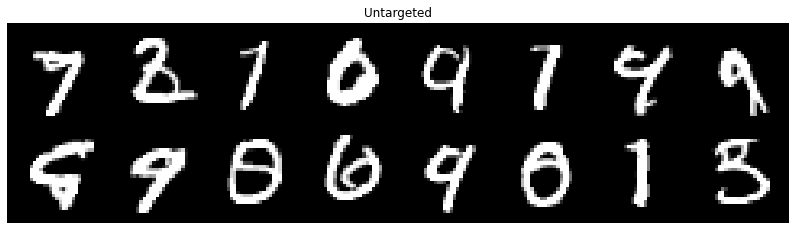

In [17]:
adv = attack.generate(X_test[:16], y_test[:16])
show_img(adv, 'Untargeted')

## Strong targeted attack

In [18]:
attack = WaterMarkAttack(eps=1.0, base=1.0, n_classes=10, x_min=0.0, x_max=1.0, targeted=True)
attack.fit(X_train, y_train)

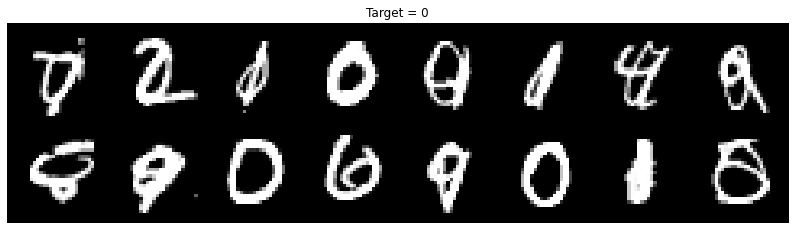

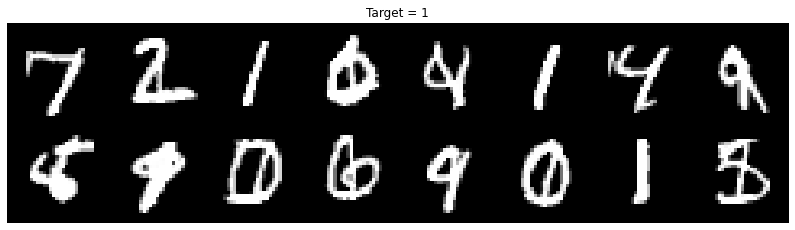

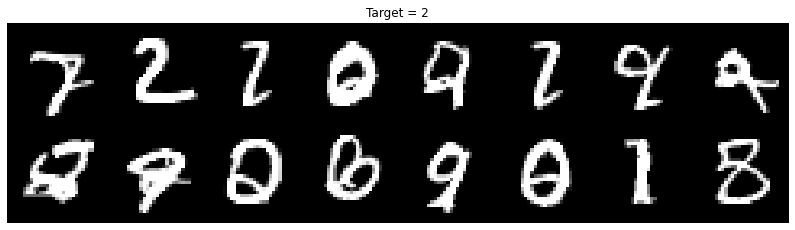

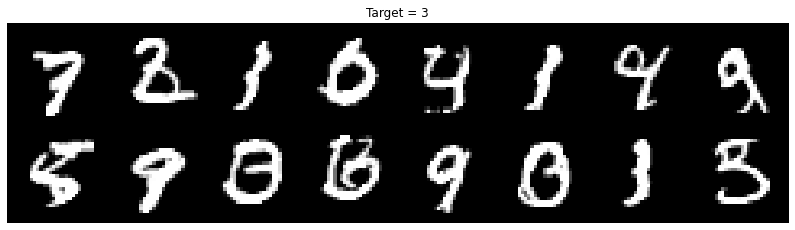

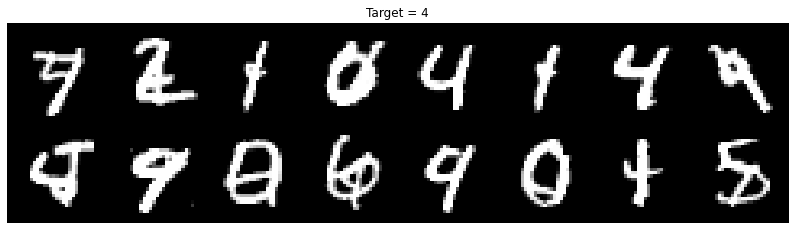

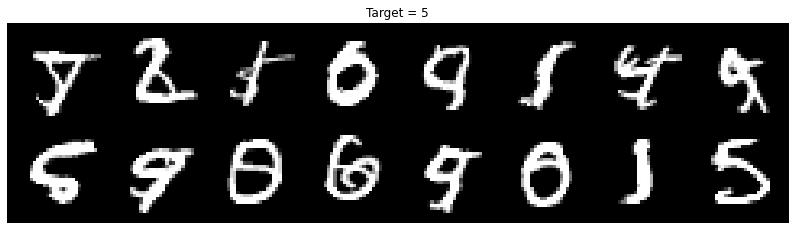

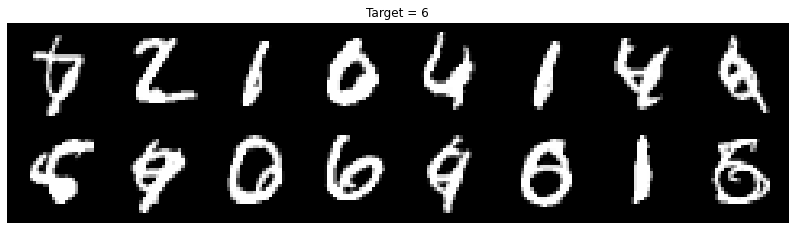

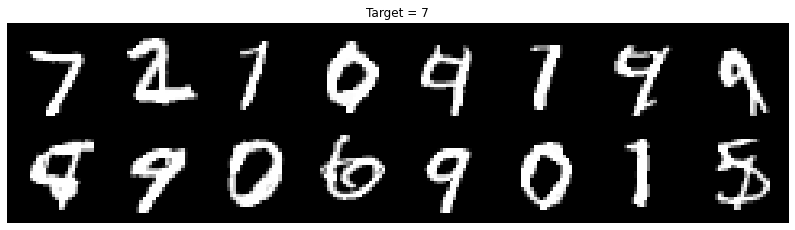

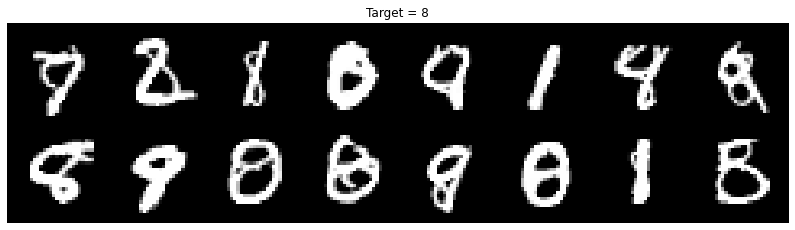

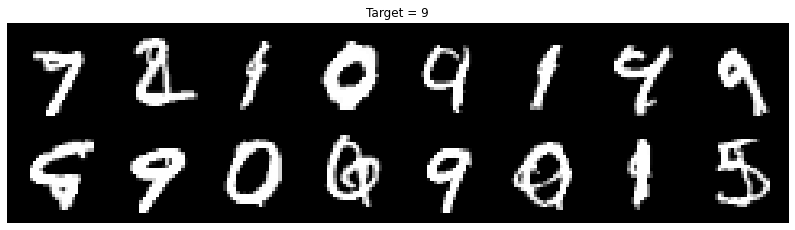

In [19]:
for i in range(10):
    adv = attack.generate(X_test[:16], i * np.ones(16, dtype=np.long))
    show_img(adv, 'Target = {}'.format(i))

## Extreme perturbations

In [20]:
attack = WaterMarkAttack(eps=1.5, base=1.0, n_classes=10, x_min=0.0, x_max=1.0, targeted=True)
attack.fit(X_train, y_train)

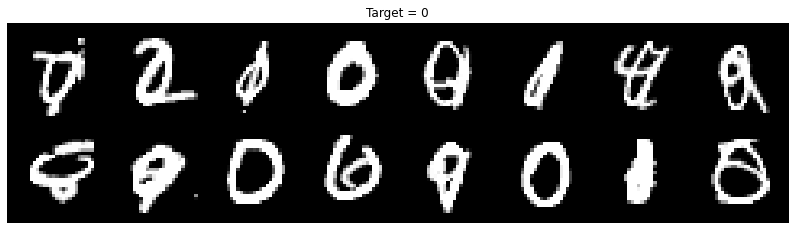

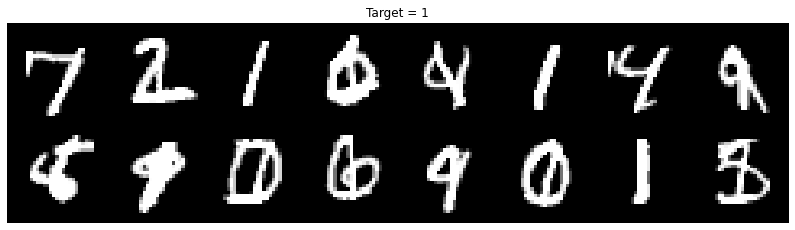

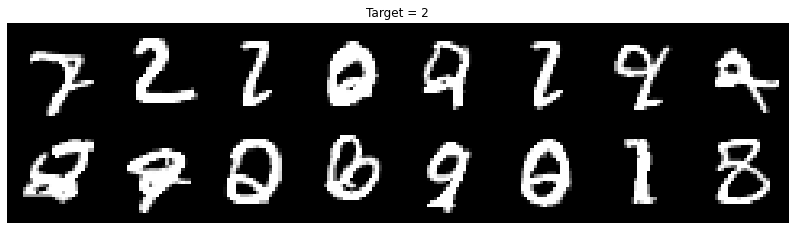

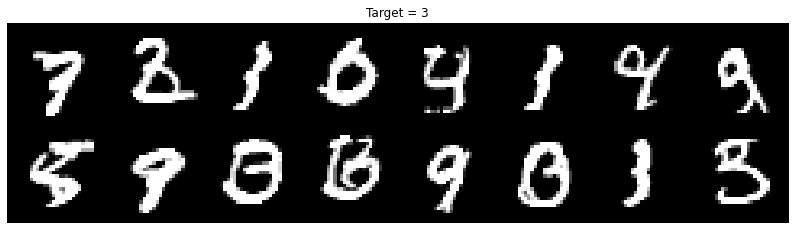

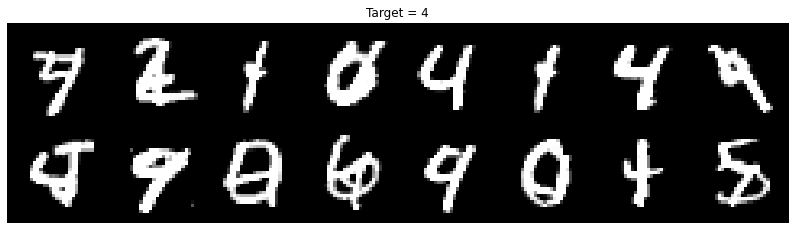

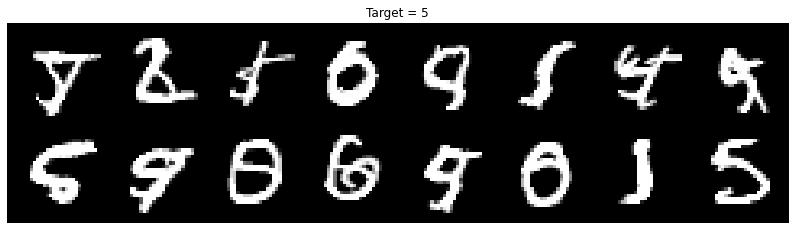

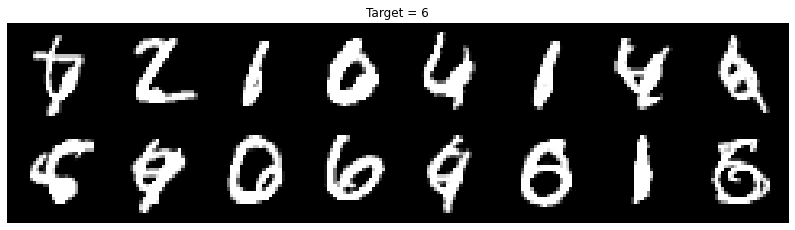

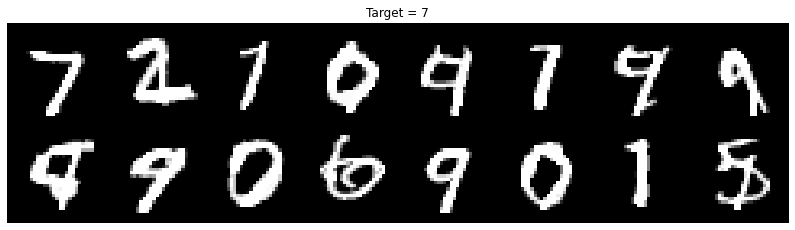

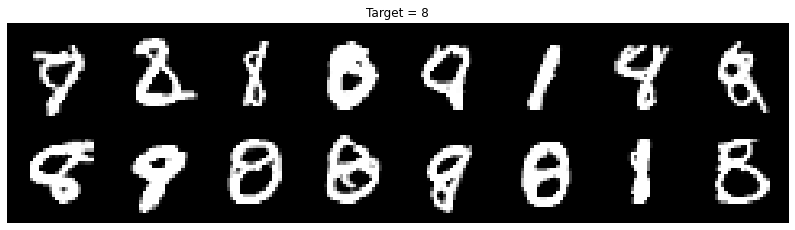

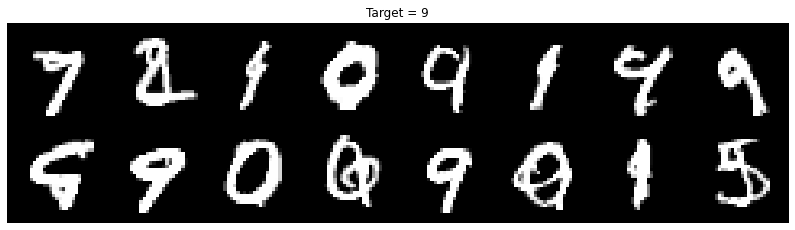

In [21]:
for i in range(10):
    adv = attack.generate(X_test[:16], i * np.ones(16, dtype=np.long))
    show_img(adv, 'Target = {}'.format(i))